In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("taxi-analysis").getOrCreate()

22/07/31 00:35:29 WARN Utils: Your hostname, singyeongdeog-ui-Macmini.local resolves to a loopback address: 127.0.0.1; using 222.98.22.103 instead (on interface en0)
22/07/31 00:35:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/07/31 00:35:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
trip_files = "/Users/singyeongdeog/Documents/github_code/data-engineering/01-spark/data/yellow/*"
zone_file = "/Users/singyeongdeog/Documents/github_code/TIL/til-by-topic/big-data/1-spark/data/taxi+_zone_lookup.csv"

In [6]:
trips_df = spark.read.csv(f"file:///{trip_files}", inferSchema = True, header = True)
zone_df = spark.read.csv(f"file:///{zone_file}", inferSchema = True, header = True)

In [7]:
trips_df.printSchema()
zone_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)

root
 |-- LocationID: string (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |--

In [8]:
trips_df.createOrReplaceTempView("trips")
zone_df.createOrReplaceTempView("zone")

In [33]:
query = """
SELECT 
    t.VendorID as vendor_id,
    TO_DATE(t.tpep_pickup_datetime) as pickup_date,
    TO_DATE(t.tpep_dropoff_datetime) as dropoff_date,
    HOUR(t.tpep_pickup_datetime) as pickup_time,
    HOUR(t.tpep_dropoff_datetime) as dropoff_time,
    passenger_count,
    t.trip_distance,
    t.fare_amount,
    t.tip_amount,
    t.tolls_amount,
    t.total_amount,
    t.payment_type,
    pz.Zone as pickup_zone,
    dz.Zone as dropoff_zone
FROM
    trips t
    LEFT JOIN
        zone pz 
    ON
        t.PULocationID = pz.LocationID
    LEFT JOIN
        zone dz
    ON
        t.DOLocationID = dz.LocationID
"""
comb_df = spark.sql(query)
comb_df.createOrReplaceTempView('comb')

In [25]:
comb_df.show()

22/07/31 00:48:46 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: id, category
 Schema: LocationID, Zone
Expected: LocationID but found: id
CSV file: file:///Users/singyeongdeog/Documents/github_code/TIL/til-by-topic/big-data/1-spark/data/restaurant_reviews.csv
+---------+-----------+------------+-----------+------------+-------------+-----------+----------+------------+------------+------------+--------------------+--------------------+
|vendor_id|pickup_date|dropoff_date|pickup_time|dropoff_time|trip_distance|fare_amount|tip_amount|tolls_amount|total_amount|payment_type|         pickup_zone|        dropoff_zone|
+---------+-----------+------------+-----------+------------+-------------+-----------+----------+------------+------------+------------+--------------------+--------------------+
|        1| 2021-01-01|  2021-01-01|          0|           0|          2.1|        8.0|       0.0|         0.0|        11.8|           2| Lincoln Square East|        Centr

In [26]:
comb_df.printSchema()

root
 |-- vendor_id: integer (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- pickup_time: integer (nullable = true)
 |-- dropoff_time: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- pickup_zone: string (nullable = true)
 |-- dropoff_zone: string (nullable = true)



In [27]:
spark.sql("SELECT pickup_date, pickup_time from comb WHERE pickup_time > 0").show()

22/07/31 00:48:49 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: id
 Schema: LocationID
Expected: LocationID but found: id
CSV file: file:///Users/singyeongdeog/Documents/github_code/TIL/til-by-topic/big-data/1-spark/data/restaurant_reviews.csv
+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2020-12-31|         23|
| 2020-12-31|         21|
| 2020-12-31|         23|
| 2020-12-31|         18|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2020-12-31|         23|
| 2020-12-31|         13|
| 2020-12-31|         23|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
+-----------+-----------+
only showing top 20 rows



In [30]:
spark.sql("SELECT pickup_date, pickup_time from comb WHERE pickup_date < '2020-12-31'").show()

22/07/31 00:49:50 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: id
 Schema: LocationID
Expected: LocationID but found: id
CSV file: file:///Users/singyeongdeog/Documents/github_code/TIL/til-by-topic/big-data/1-spark/data/restaurant_reviews.csv


+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2009-01-01|          0|
| 2008-12-31|         23|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          1|
| 2009-01-01|         17|
| 2009-01-01|         17|
| 2009-01-01|         18|
| 2009-01-01|          1|
| 2009-01-01|          1|
| 2009-01-01|          2|
| 2009-01-01|          2|
| 2009-01-01|          0|
+-----------+-----------+
only showing top 20 rows



In [31]:
comb_df.select("total_amount").describe().show()

22/07/31 00:51:13 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: id
 Schema: LocationID
Expected: LocationID but found: id
CSV file: file:///Users/singyeongdeog/Documents/github_code/TIL/til-by-topic/big-data/1-spark/data/restaurant_reviews.csv


+-------+------------------+
|summary|      total_amount|
+-------+------------------+
|  count|          15182580|
|   mean| 18.88254283413038|
| stddev|144.91087057197095|
|    min|            -647.8|
|    max|          398469.2|
+-------+------------------+



In [32]:
comb_df.select("trip_distance").describe().show()

22/07/31 00:51:39 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: id
 Schema: LocationID
Expected: LocationID but found: id
CSV file: file:///Users/singyeongdeog/Documents/github_code/TIL/til-by-topic/big-data/1-spark/data/restaurant_reviews.csv


+-------+-----------------+
|summary|    trip_distance|
+-------+-----------------+
|  count|         15182580|
|   mean|6.702411167271958|
| stddev|674.5041546489061|
|    min|              0.0|
|    max|        332541.19|
+-------+-----------------+



In [34]:
comb_df.select("passenger_count").describe().show()

22/07/31 00:52:24 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: id
 Schema: LocationID
Expected: LocationID but found: id
CSV file: file:///Users/singyeongdeog/Documents/github_code/TIL/til-by-topic/big-data/1-spark/data/restaurant_reviews.csv


+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|          14324093|
|   mean| 1.425325778044027|
| stddev|1.0442640081415573|
|    min|               0.0|
|    max|               9.0|
+-------+------------------+



In [36]:
query = """
SELECT 
    DATE_TRUNC('MM', c.pickup_date) as month,
    COUNT(*) AS trips
FROM
    comb c
GROUP BY
    month
ORDER BY
    month desc
"""
spark.sql(query).show()

22/07/31 00:54:41 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: id
 Schema: LocationID
Expected: LocationID but found: id
CSV file: file:///Users/singyeongdeog/Documents/github_code/TIL/til-by-topic/big-data/1-spark/data/restaurant_reviews.csv


+-------------------+-------+
|              month|  trips|
+-------------------+-------+
|2029-05-01 00:00:00|      1|
|2021-12-01 00:00:00|      5|
|2021-11-01 00:00:00|      6|
|2021-10-01 00:00:00|      3|
|2021-09-01 00:00:00|      3|
|2021-08-01 00:00:00|     36|
|2021-07-01 00:00:00|2858424|
|2021-06-01 00:00:00|2869072|
|2021-05-01 00:00:00|2537413|
|2021-04-01 00:00:00|2196075|
|2021-03-01 00:00:00|1947406|
|2021-02-01 00:00:00|1387966|
|2021-01-01 00:00:00|1386012|
|2020-12-01 00:00:00|     16|
|2009-01-01 00:00:00|    113|
|2008-12-01 00:00:00|     26|
|2004-04-01 00:00:00|      1|
|2003-01-01 00:00:00|      1|
|2002-12-01 00:00:00|      1|
+-------------------+-------+



In [37]:
# Data Cleaning
query = """
SELECT 
    *
FROM
    comb c
WHERE
    c.total_amount < 5000
    AND c.total_amount > 0 
    AND c.trip_distance < 100
    AND c.passenger_count < 4
    AND c.pickup_date >= '2021-01-01'
    AND c.pickup_date < '2021-08-01'
"""

cleaned_df = spark.sql(query)
cleaned_df.createOrReplaceTempView("cleaned")

In [38]:
cleaned_df.describe().show()

22/07/31 00:57:04 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: id, category
 Schema: LocationID, Zone
Expected: LocationID but found: id
CSV file: file:///Users/singyeongdeog/Documents/github_code/TIL/til-by-topic/big-data/1-spark/data/restaurant_reviews.csv


+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+--------------------+
|summary|         vendor_id|       pickup_time|      dropoff_time|   passenger_count|     trip_distance|       fare_amount|        tip_amount|       tolls_amount|      total_amount|       payment_type|         pickup_zone|        dropoff_zone|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+--------------------+
|  count|          13444300|          13444300|          13444300|          13444300|          13444300|          13444300|          13444300|           13444300|          13444300|           13444300|            13444300|            13444300|
|   mean|1.6708428107078

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [40]:
query = """
SELECT 
    c.pickup_date,
    COUNT(*) AS trips
FROM
    cleaned c
GROUP BY
    c.pickup_date
"""
pd_df = spark.sql(query).toPandas()

22/07/31 00:59:50 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: id
 Schema: LocationID
Expected: LocationID but found: id
CSV file: file:///Users/singyeongdeog/Documents/github_code/TIL/til-by-topic/big-data/1-spark/data/restaurant_reviews.csv


<AxesSubplot:xlabel='pickup_date', ylabel='trips'>

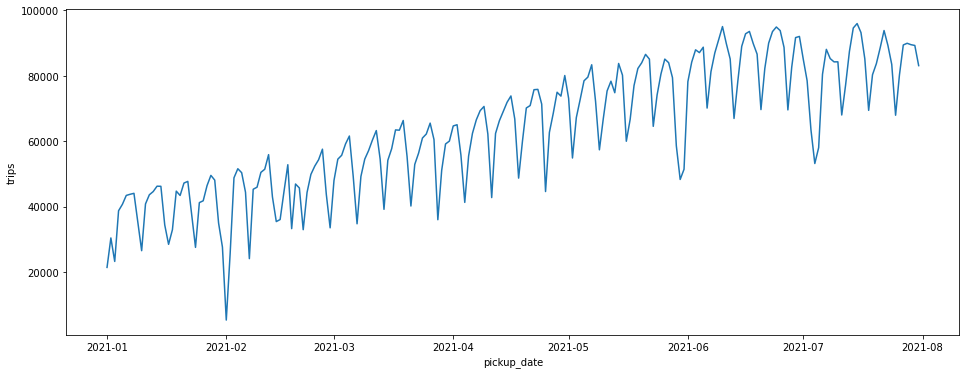

In [41]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.lineplot(x="pickup_date", y="trips", data=pd_df)

In [42]:
query = """
SELECT 
    c.pickup_date,
    DATE_FORMAT(c.pickup_date, 'EEEE') AS day_of_week,
    COUNT(*) AS trips
FROM
    cleaned c
GROUP BY
    c.pickup_date,
    day_of_week
"""
pd_df2 = spark.sql(query).toPandas()

22/07/31 01:02:01 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: id
 Schema: LocationID
Expected: LocationID but found: id
CSV file: file:///Users/singyeongdeog/Documents/github_code/TIL/til-by-topic/big-data/1-spark/data/restaurant_reviews.csv


In [43]:
data = pd_df2.groupby("day_of_week").trips.median().to_frame().reset_index()
data["sort_dow"] = data["day_of_week"].replace({ # 원하는 순서로 정렬하기 위해 preprocessing
    "Sunday": 0,
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday": 5,
    "Saturday": 6,
})

In [44]:
data.sort_values(by="sort_dow", inplace=True)

<AxesSubplot:xlabel='day_of_week', ylabel='trips'>

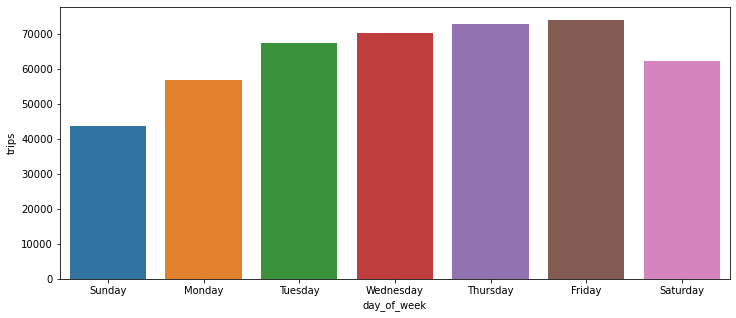

In [45]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(
    x="day_of_week",
    y="trips",
    data=data
)

In [46]:
def get_weekday(data):
    import calendar
    return calendar.day_name[date.weekday()]

spark.udf.register("get_weekday", get_weekday)

<function __main__.get_weekday(data)>

In [48]:
query = """
SELECT 
    c.pickup_date,
    get_weekday(c.pickup_date) AS day_of_week,
    COUNT(*) AS trips
FROM
    cleaned c
GROUP BY
    c.pickup_date,
    day_of_week
"""


In [49]:
# Payment Type에 따른 사용자 패턴 분석 

<function __main__.parse_payment_type(payment_type)>

In [50]:
payment_type_to_string = {
    1: "Credit Card",
    2: "Cash",
    3: "No Charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided Trip",
}
def parse_payment_type(payment_type):
    return payment_type_to_string[payment_type]

spark.udf.register("parse_payment_type", parse_payment_type)

22/07/31 01:06:19 WARN SimpleFunctionRegistry: The function parse_payment_type replaced a previously registered function.


<function __main__.parse_payment_type(payment_type)>

In [51]:
query = """
SELECT 
    parse_payment_type(payment_type),
    count(*) AS trips,
    MEAN(fare_amount) AS mean_fare_amount,
    STD(fare_amount) AS stdev_fare_amount
FROM
    cleaned
GROUP BY
    payment_type
"""

spark.sql(query).show()

22/07/31 01:06:29 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: id
 Schema: LocationID
Expected: LocationID but found: id
CSV file: file:///Users/singyeongdeog/Documents/github_code/TIL/til-by-topic/big-data/1-spark/data/restaurant_reviews.csv


+--------------------------------+--------+------------------+------------------+
|parse_payment_type(payment_type)|   trips|  mean_fare_amount| stdev_fare_amount|
+--------------------------------+--------+------------------+------------------+
|                     Credit Card|10215169|12.319930962473373|11.028816342090348|
|                       No Charge|   59651|11.993199443429283|15.208418535529024|
|                         Dispute|   23968| 12.74692214619492|14.360333740545434|
|                            Cash| 3145511|12.047340896280424| 11.60067907728248|
|                         Unknown|       1|              17.8|              null|
+--------------------------------+--------+------------------+------------------+

